In [93]:
# Базовые операции шифрования с использованием эллиптических кривых
import collections

def inv(n, q):
    """div on PN modulo a/b mod q as a * inv(b, q) mod q
    >>> assert n * inv(n, q) % q == 1
    """
    for i in range(q):
        if (n * i) % q == 1:
            return i
        pass
    assert False, "unreached"
    pass


def sqrt(n, q):
    """sqrt on PN modulo: returns two numbers or exception if not exist
    >>> assert (sqrt(n, q)[0] ** 2) % q == n
    >>> assert (sqrt(n, q)[1] ** 2) % q == n
    """
    assert n < q
    for i in range(1, q):
        if i * i % q == n:
            return (i, q - i)
        pass
    raise Exception("not found")


Coord = collections.namedtuple("Coord", ["x", "y"])


class EC(object):
    """System of Elliptic Curve"""
    def __init__(self, a, b, q):
        """elliptic curve as: (y**2 = x**3 + a * x + b) mod q
        - a, b: params of curve formula
        - q: prime number
        """
        assert 0 < a and a < q and 0 < b and b < q and q > 2
        assert (4 * (a ** 3) + 27 * (b ** 2))  % q != 0
        self.a = a
        self.b = b
        self.q = q
        # just as unique ZERO value representation for "add": (not on curve)
        self.zero = Coord(0, 0)
        pass

    def is_valid(self, p):
        if p == self.zero: return True
        l = (p.y ** 2) % self.q
        r = ((p.x ** 3) + self.a * p.x + self.b) % self.q
        return l == r

    def at(self, x):
        """find points on curve at x
        - x: int < q
        - returns: ((x, y), (x,-y)) or not found exception
        >>> a, ma = ec.at(x)
        >>> assert a.x == ma.x and a.x == x
        >>> assert a.x == ma.x and a.x == x
        >>> assert ec.neg(a) == ma
        >>> assert ec.is_valid(a) and ec.is_valid(ma)
        """
        assert x < self.q
        ysq = (x ** 3 + self.a * x + self.b) % self.q
        y, my = sqrt(ysq, self.q)
        return Coord(x, y), Coord(x, my)

    def neg(self, p):
        """negate p
        >>> assert ec.is_valid(ec.neg(p))
        """
        return Coord(p.x, -p.y % self.q)

    def add(self, p1, p2):
        """<add> of elliptic curve: negate of 3rd cross point of (p1,p2) line
        >>> d = ec.add(a, b)
        >>> assert ec.is_valid(d)
        >>> assert ec.add(d, ec.neg(b)) == a
        >>> assert ec.add(a, ec.neg(a)) == ec.zero
        >>> assert ec.add(a, b) == ec.add(b, a)
        >>> assert ec.add(a, ec.add(b, c)) == ec.add(ec.add(a, b), c)
        """
        if p1 == self.zero: return p2
        if p2 == self.zero: return p1
        if p1.x == p2.x and (p1.y != p2.y or p1.y == 0):
            # p1 + -p1 == 0
            return self.zero
        if p1.x == p2.x:
            # p1 + p1: use tangent line of p1 as (p1,p1) line
            l = (3 * p1.x * p1.x + self.a) * inv(2 * p1.y, self.q) % self.q
            pass
        else:
            l = (p2.y - p1.y) * inv(p2.x - p1.x, self.q) % self.q
            pass
        x = (l * l - p1.x - p2.x) % self.q
        y = (l * (p1.x - x) - p1.y) % self.q
        return Coord(x, y)

    def mul(self, p, n):
        """n times <mul> of elliptic curve
        >>> m = ec.mul(p, n)
        >>> assert ec.is_valid(m)
        >>> assert ec.mul(p, 0) == ec.zero
        """
        r = self.zero
        m2 = p
        # O(log2(n)) add
        while 0 < n:
            if n & 1 == 1:
                r = self.add(r, m2)
                pass
            n, m2 = n >> 1, self.add(m2, m2)
            pass
        return r

    def order(self, g):
        """order of point g
        >>> o = ec.order(g)
        >>> assert ec.is_valid(a) and ec.mul(a, o) == ec.zero
        >>> assert o <= ec.q
        """
        assert self.is_valid(g) and g != self.zero
        for i in range(1, self.q + 1):
            if self.mul(g, i) == self.zero:
                return i
            pass
        raise Exception("Invalid order")
    pass


class ElGamal(object):
    """ElGamal Encryption
    pub key encryption as replacing (mulmod, powmod) to (ec.add, ec.mul)
    - ec: elliptic curve
    - g: (random) a point on ec
    """
    def __init__(self, ec, g):
        assert ec.is_valid(g)
        self.ec = ec
        self.g = g
        self.n = ec.order(g)
        pass

    def key_gen(self, priv):
        """generate pub key
        - priv: priv key as (random) int < ec.q
        - returns: pub key as points on ec
        """
        return self.ec.mul(g, priv)

    def enc(self, plain, pub, r):
        """encrypt
        - plain: data as a point on ec
        - pub: pub key as points on ec
        - r: randam int < ec.q
        - returns: (cipher1, ciper2) as points on ec
        """
        assert self.ec.is_valid(plain)
        assert self.ec.is_valid(pub)
        return (self.ec.mul(g, r), self.ec.add(plain, self.ec.mul(pub, r)))

    def dec(self, cipher, priv):
        """decrypt
        - chiper: (chiper1, chiper2) as points on ec
        - priv: private key as int < ec.q
        - returns: plain as a point on ec
        """
        c1, c2 = cipher
        assert self.ec.is_valid(c1) and ec.is_valid(c2)
        return self.ec.add(c2, self.ec.neg(self.ec.mul(c1, priv)))
    pass

In [102]:
    ec = EC(1, 18, 19)
    g, _ = ec.at(7)
    assert ec.order(g) <= ec.q
    
    eg = ElGamal(ec, g)
    mapping = [ec.mul(g, i) for i in range(eg.n)]
    print("Кол-во точек в поле:",len(mapping))
    #print(mapping[1])
    #print(ec.add(mapping[1],mapping[2]))

    plain = mapping[7] 
    print('Кодируемая:', plain)
    priv = 113
    pub = eg.key_gen(priv)
    
    print('Публичный ключ:',pub)
    print('Приватный ключ:',priv)
    cipher = eg.enc(plain, pub, 15)
    print('Шифрованная пара:', cipher)
    decoded = eg.dec(cipher, priv)
    print(decoded)
    assert decoded == plain
    assert cipher != pub

Кол-во точек в поле: 19
Кодируемая: Coord(x=15, y=11)
Публичный ключ: Coord(x=7, y=11)
Приватный ключ: 113
Шифрованная пара: (Coord(x=8, y=14), Coord(x=1, y=1))
Coord(x=15, y=11)


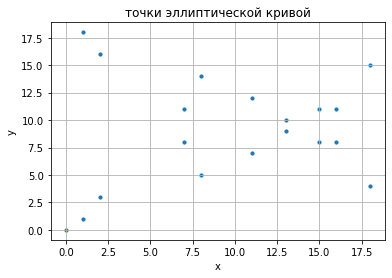

In [95]:
# Визуализация точек эллиптической кривой 
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
x=[]
y=[]
for i in mapping:
  x.append(i[0])
  y.append(i[1])
plt.title('точки эллиптической кривой')
plt.scatter(x,y,s=10)
plt.xlabel("x")
plt.ylabel ("y")
plt.grid(True)
plt.show()